# Autopilot at Tesla

- Image: (3, 960, 1280)
- ResNet-50 like Backbone
- FPN- DeepLabV3 - UNet <- like heads 
- ~15 tasks but then, those tasks have sub-tasks like object detection has the subtask of stationary object vs. moving object etc.

Goals:
- Be able to access another camera's scene to predict the depth of the scene in front of the car.
- Stitching up images across space and time happens with RNNs.
- One RNN takes in scenes from the camera and creates 3D space
- 8 hydronets that share backbone neural nets to predict different objects 
- R-CNNs on videso?
    - 8 cameras, 16 time steps, 32-batch_size: 8 * 16 * 32 -> 4096 images 
    
Requires a combination of data parallel and model parallel training


## Tasks:
- Explore ResNet50
- Check transfer learning w/ ResNet50
- Explore adding heads to models


In ResNets, let's say we desire underlying mapping of H(x):
if we let the stacked nonlinear layers fit another mapping of F(x):=H(x) - x, the original mapping will be recast to F(x) + x.
Hypothesis is that it is easier to optimize the residual mapping than to optimize the original, unreferenced mapping. If an identity mapping i.e. layers added to the shallower architecture to make it deeper, if the identity mapping is optimal, it is eaasier to push the residual to zero than to fit an identity mapping by a stack of nonlinear layers.

We formulate the F(x) + x by making use of feedforward NNs with "shortcut connections" i.e. skipping one or more layers. The shortcuts do not add any parameters and their outputs are simply added to the outputs of the stacked layers.

### Two results:
1. Extremely deep residual nets are easy to optimize vs. the counterpart "plain" nets that have simply stack layers, show greater training error when the depth increases.
2. Our deep residual nets can easily enjoy accuracy gains from greatly increase depth, producing results substantially better than previous networks.

### Residual Learning:
Let's say:
H(x)
This follows the idea of the degradation i.e. if we have a shallow function with identity mapping layers on top of it, the training error should be no greater than its shallower counter-part. With residual functions, if identity mappings are optimal, the solvers may simply drive the weights of the multiple nonlinear layers toward zero to approach identity mappings. 

### Identity Mapping by shortcutes

The residual learning is present after every few stacked layers. 

## Coding ResNet50

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

In [2]:
# let's define a pre-activation non-bottleneck residual block
# In bottleneck residual block, first we do 1 x 1 convolution to downsample the input volume depth
# then, we apply a 3x3(bottleneck) convolution to the reduced input
class PreActivationBlock(nn.Module):
    """PreActivation Residual Block i.e. no ReLU after adding x."""
    
    expansion = 1
    
    def __init__(self, in_slices, slices, stride=1):   # learnable block components
        super(PreActivationBlock, self).__init__()     # convolution and batch normalization
        
        self.bn_1 = nn.BatchNorm2d(in_slices)          # pass in the image or input if it is second block
        self.conv_1 = nn.Conv2d(in_channels=in_slices, out_channels=slices,      # output is the slices, which gets
                               kernel_size=3,stride=stride,padding=1,            # passed into the second bn and conv layer
                               bias=False)
        
        self.bn_2 = nn.BatchNorm2d(slices)
        self.conv_2 = nn.Conv2d(in_channels=slices, out_channels=slices,
                                kernel_size=3, stride=1, padding=1,
                                bias=False)
        
        # after we define the layer, we check if the output of the block is the same as the x input
        # if not, we use convolutions for the shortcut
        # REMEMBER: x remains the same. 
                        # in_slices is the input here and now, we are checking
            # if in_slices is not equal to slices from the last conv layer:
            # the shortcut is going to be convolved by a 1x1 filter with the same stride
            # and output channels as the one in the main path
        if stride != 1 or in_slices != self.expansion * slices:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_slices,
                          out_channels=self.expansion*slices,     # self.expansion is a hyperparamter
                          kernel_size=1,                     # that allows us to expand the output depth of the res block
                          stride=stride,
                          bias=False)
            )
            
    # define the forward function
    def forward(self, x):
        # take the x and after batch norm, apply Relu to every single element of that
        out = F.relu(self.bn_1(x))     # perform ReLU on the first batch norm.
        # we define ReLU in the forward method because it does not have learnable parameters
        
        # reuse bn+relu in down-sampling layers
        # if the shortcut connection had to do convolution because the dimensions differed
        # between input/ouput dimension, we will reuse F.relu(self.bn_1(x))
        # we will perform ReLU non-linearity and batch normalization to the shortcut
        # if, however, x had equal dimensions as out, we will keep it untouched
        
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        
        # then we pass that to the first conv layer
        out = self.conv_1(out)
        out = F.relu(self.bn_2(out))
        out = self.conv_2(out)
        # add output of the second conv layer to the shortcut
        out += shortcut
        return out
    

In [3]:
# let's implement the residual network itself:
class PreActivationResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        """
        :param block: type of residual block (regular or bottleneck)
        :param num_blocks: a list with 4 int values.
             Each value reflects the number of residual blocks in the group
        :param num_classes: number of output classes
        """
        super(PreActivationResNet, self).__init__()


    
        self.in_slices=64
        
        # we define the first layer
        # in the original resnet as well, we first convolved it with 7x7 conv
        # with 64 output channels 
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64,
                                kernel_size=3, stride=1, padding=1,
                                bias=False)
        # the network has 4 groups of residual blocks, just like the original
        # implementation
        self.layer_1 = self._make_group(block, 64, num_blocks[0], stride=1)
        self.layer_2 = self._make_group(block, 128, num_blocks[1], stride=2)
        self.layer_3 = self._make_group(block, 256, num_blocks[2], stride=2)
        self.layer_4 = self._make_group(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_group(self, block, slices, num_blocks, stride):
        """
        create on residual group
        """
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_slices, slices, stride))
            self.in_slices = slices * block.expansion

        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv_1(x)
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out
        

In [4]:
# resnet configuration with 34 layers:
def PreActivationResNet34():
    return PreActivationResNet(block=PreActivationBlock,
                               num_blocks = [3,4,6,3])

In [5]:
PreActivationResNet34().eval()

PreActivationResNet(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer_1): Sequential(
    (0): PreActivationBlock(
      (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActivationBlock(
      (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): PreActivationBlock(
      (bn_1): 

In [6]:
def train_model(model, loss_function, optimizer, data_loader):
    """Train one Epoch"""
    
    # set training mode
    model.train()
    
    current_loss = 0.0
    current_acc = 0
    
    # iterate over the training data
    for i, (inputs, labels) in enumerate(data_loader):
        # forward
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(True):
            # forward
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)
            
            # backward
            loss.backward()
            optimizer.step()
            
        # stats
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)
        
    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)
    
    print('Train Loss: {.4f}; Accuracy: {.4f}'.format(total_loss, total_acc))
    

In [7]:
# define function to test a single epoch
def test_model(model, loss_function, data_loader):
    """Test for a single epoch"""
    
    # set model for eval mode:
    model.eval()
    
    current_loss = 0.0
    current_acc = 0
    
    # iterate over the validation data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)
            
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)
        
    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)
    
    print('Test Loss: {.4f}; Accuracy: {.4f}'.format(total_loss, total_acc))
    
    return total_loss, total_acc

### The network has been defined, now load the data:

In [7]:
# training data transformation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435, 0.2616))
])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True,
                                         transform=transform_train)
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=100,
                                           shuffle=True,
                                           num_workers=2)

# transform the test data - no randomcrop or RandomHorizontalFlip
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435, 0.2616))

])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True,
                                         transform=transform_test)
test_loader = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size=100,
                                          shuffle=False,
                                          num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [12]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435, 0.2616))
])
train_set_2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download = True,
                                         transform = transform_train)
train_loader_2 = torch.utils.data.DataLoader(dataset=train_set_2,
                                           batch_size=100,
                                           shuffle=True,
                                           num_workers=2)

Files already downloaded and verified


In [13]:
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(train_set_2[139][0])



In [15]:
train_set_2[139][1]

8

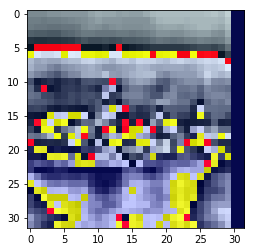

In [14]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


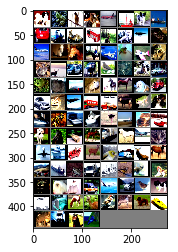

  dog  frog  bird   cat plane  ship   dog  ship   car truck  deer truck  deer  bird plane  frog plane   cat horse horse plane  frog plane  frog  frog  deer   car truck  bird  bird   dog   car  frog   cat plane  frog horse horse   dog truck   car  frog plane truck   car  deer  frog   dog  ship  frog  ship   cat  bird plane   cat  ship   dog horse  frog  deer truck horse plane   cat plane  ship truck  deer  bird truck  deer  deer plane  ship  frog truck  ship  bird  deer   dog  ship   dog  ship   car plane   car  bird   dog plane truck horse  deer  bird horse   dog  ship  frog truck horse plane


In [16]:
# let's display a lot more pictures:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

data_iter = iter(train_loader)
images, labels = data_iter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(100)))

In [12]:
def plot_accuracy(accuracy: list):
    """Plot accuracy"""
    plt.figure()
    plt.plot(accuracy)
    plt.xticks(
        [i for i in range(0, len(accuracy))],
        [i + 1 for i in range(0, len(accuracy))])
    
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

In [ ]:
plt.accuracy(test_acc)

# PreActivationBottleNeckResNet

50-layer resnet is created with residual blocks that have 3 layers instead of two.
The 3 layers have convolutions in this order: 1x1, 3x3, 1x1 .. the shortcuts are identity shortcuts because projection shortcuts where we multiply the input with Ws matrix would add parameters such that it doubles the number of parameters in the model. 
The dimensions of the last 1x1 convolution output matches those of the input so it makes the residual connection easier.


In [9]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms

# functional is the module that has layers and the layer structures define i.e. conv1d, conv2d, conv3d etc.


In [10]:
# let's create a preactivation bottleneck block that has three layers:

class PreActivationBottleneckBlock(nn.Module):
    expansion = 4    # allows us to expand the output depth of the res block
    def __init__(self, in_slices, slices, stride=1):
        super(PreActivationBottleneckBlock, self).__init__()
            
        self.bn_1 = nn.BatchNorm2d(in_slices)
        self.conv_1 = nn.Conv2d(in_channels=in_slices, out_channels=slices,
                               kernel_size=1, stride=stride, padding=1,
                               bias=False)

        
        self.bn_2 = nn.BatchNorm2d(slices)
        self.conv_2 = nn.Conv2d(in_channels=slices, out_channels=slices,
                                kernel_size=3, stride=stride, padding=1,
                                bias=False)
        
        self.bn_3 = nn.BatchNorm2d(slices)
        self.conv_3 = nn.Conv2d(in_channels=slices, out_channels=self.expansion*slices,
                                kernel_size=1, stride=stride, padding=1,
                                bias=False)
        
        if stride != 1 or in_slices != self.expansion * slices:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_slices,
                          out_channels=self.expansion * slices,
                          kernel_size=1,
                          stride=stride,
                          bias=False))
            
        # this is it for the bottleneck block..
        # Now we define the forward function
        def forward(self, x):
            
            out = F.relu(self.bn_1(x))
            
            shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
            
            out = self.conv_1(out)
            out = F.relu(self.bn_2(out))
            out = self.conv_2(out)
            out = F.relu(self.bn_3(out))
            out = self.conv_3(out)
            
            out += shortcut
            return out
        
            

In [18]:
class PreActivationResNet(nn.Module):
    
    def __init__(self, block, num_blocks, num_classes=10):
        """
        param block: type of residual block i.e. regular or bottleneck
        param num_blocks: how many of the above type blocks in a group
        param num_classes: number of output classes
        """
        super(PreActivationResNet, self).__init__()
        
        self.in_slices = 64
        
        # define the first layer that is a 3x3 conv:
        # remember this is the layer outside of the blocks and the output of this is passed into
        # the first block
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64,
                                kernel_size=3, stride=1, padding=1,
                                bias=False)
        # now implement the block groups:
        
        self.layer_1 = self._make_group(block, 64, num_blocks[0], stride=1)
        self.layer_2 = self._make_group(block, 128, num_blocks[1], stride=2)
        self.layer_3 = self._make_group(block, 256, num_blocks[2], stride=2)
        self.layer_4 = self._make_group(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_group(self, block, slices, num_blocks, stride):
        """
        create a res group
        """
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_slices, slices, stride))
            self.in_slices = slices * block.expansion
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv_1(x)
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = F.avg_pool2d(out, 4)    # input from previous layer, kernel size =4
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

In [19]:
def PreActivationResNet50():
    return PreActivationResNet(block = PreActivationBottleneckBlock,
                               num_blocks = [3, 4, 6, 3])

In [20]:
def train_model(model, loss_function, optimizer, data_loader):
    """Train one epoch"""
    
    # set the model to training model
    model.train()
    
    current_loss = 0.0
    current_acc = 0
    
    # iterate over the training data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the inputs/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()   # during backprop, the gradient is replaced with this,
        # otherwise, it will be accumulating the gradients
        
        with torch.set_grad_enabled(True):
            # forward propagate
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)
            #backward
            loss.backward()
            optimizer.step()
            
        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)
        
    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double()/ len(data_loader.dataset)
    
    print('Train Loss: {:.4f}; Accuracy {:.4f}'.format(total_loss, total_acc))
    

In [21]:
def test_model(model, loss_function, data_loader):
    """Test for a single Epoch"""
    
    # set the model in eval mode:
    model.eval()
    
    current_loss = 0.0
    current_acc = 0
    
    # iterate over the validation data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/ labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)
            
        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions ==labels.data)
    
    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)
    
    print('Test Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss, total_acc))
    
    return total_loss, total_acc

In [22]:
def plot_accuracy(accuracy:list):
    """plot accuracy"""
    
    plt.figure()
    plt.plot(accuracy)
    plt.xticks(
        [i for i in range(0, len(accuracy))],
        [i+1 for i in range(0, len(accuracy))])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    

In [27]:
# Copy Paste

In [28]:
class PreActivationBottleneckBlock(nn.Module):
    """Pre-activation bottleneck residual block."""

    expansion = 4

    def __init__(self, in_slices, slices, stride=1):
        super(PreActivationBottleneckBlock, self).__init__()

        self.bn_1 = nn.BatchNorm2d(in_slices)
        self.conv_1 = nn.Conv2d(in_channels=in_slices, out_channels=slices,
                                kernel_size=1,
                                bias=False)

        self.bn_2 = nn.BatchNorm2d(slices)
        self.conv_2 = nn.Conv2d(in_channels=slices, out_channels=slices,
                                kernel_size=3, stride=stride, padding=1,
                                bias=False)

        self.bn_3 = nn.BatchNorm2d(slices)
        self.conv_3 = nn.Conv2d(in_channels=slices,
                                out_channels=self.expansion * slices,
                                kernel_size=1,
                                bias=False)

        # if the input/output dimensions differ use convolution for the shortcut
        if stride != 1 or in_slices != self.expansion * slices:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_slices,
                          out_channels=self.expansion * slices,
                          kernel_size=1, stride=stride,
                          bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn_1(x))

        #  reuse bn+relu in down-sampling layers
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x

        out = self.conv_1(out)

        out = F.relu(self.bn_2(out))
        out = self.conv_2(out)

        out = F.relu(self.bn_3(out))
        out = self.conv_3(out)

        out += shortcut

        return out


class PreActivationResNet(nn.Module):
    """Pre-activation residual network"""

    def __init__(self, block, num_blocks, num_classes=10):
        """
        :param block: type of residual block (regular or bottleneck)
        :param num_blocks: a list with 4 integer values.
            Each value reflects the number of residual blocks in the group
        :param num_classes: number of output classes
        """

        super(PreActivationResNet, self).__init__()

        self.in_slices = 64

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64,
                                kernel_size=3, stride=1, padding=1,
                                bias=False)

        self.layer_1 = self._make_group(block, 64, num_blocks[0], stride=1)
        self.layer_2 = self._make_group(block, 128, num_blocks[1], stride=2)
        self.layer_3 = self._make_group(block, 256, num_blocks[2], stride=2)
        self.layer_4 = self._make_group(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_group(self, block, slices, num_blocks, stride):
        """Create one residual group"""

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_slices, slices, stride))
            self.in_slices = slices * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv_1(x)
        out = self.layer_1(out)
        out = self.layer_2(out)
        out = self.layer_3(out)
        out = self.layer_4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out



In [29]:
def PreActivationResnet50():
    return PreActivationResNet(block=PreActivationBottleneckBlock,
                              num_blocks=[3, 4, 6, 3])

In [8]:
model = torchvision.models.resnet50(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [11]:
model = torchvision.models.resnet50(pretrained=True)
model.load_state_dict(torch.load('resnet50_25.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F